In [2]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy import spatial
import matplotlib.pyplot as plt
from astropy.table import Table
import emcee
import corner
import pdb
import fsps

(a)

From problem1, I decide to use age = 14 Gyr, z=0.0002 for M92. As default, I'm using MILES spectral library and MIST isochrone library.

In [3]:
# get the isochrone
def calc_VI(age, z, D, AV, AI):
    sp = fsps.StellarPopulation(compute_vega_mags=True, sfh=0, zcontinuous=z)
    mags = sp.get_mags(bands=['wfc_acs_f606w', 'wfc_acs_f814w'], tage=age )
    V = mags.T[0]
    I = mags.T[1]

    V_obs = V + D + AV
    I_obs = I + D + AI
    
    return V_obs, I_obs

V_true, I_true = calc_VI(14, 0.0002, 14.9, 0.048, 0.034)
print('V_true = %.2f, I_true = %.2f' %(V_true, I_true))

V_true = 21.07, I_true = 20.43


(b)

In [67]:
sig = 0.1
V_obs, I_obs = np.random.normal((V_true, I_true), sig)
print('V_obs = %.2f, I_obs = %.2f' %(V_obs, I_obs))

V_obs = 21.21, I_obs = 20.33


In [72]:
def lnprior(theta):
    age, z, D, AV, AI = theta
    if age>10 and age<16:
        ln_age = 0
    else:
        ln_age = -np.inf
        
    if z>0 and z<0.001:
        ln_z = 0
    else:
        ln_z = -np.inf   
    
    D_mean = 14.9
    D_error = 0.1
    ln_D = -np.log(D_error) - (D-D_mean)**2/(2*D_error**2)
    
    ln_p = ln_age + ln_z + ln_D
    
    return ln_p

def lnlike(theta, V_obs, I_obs):
    age, z, D, AV, AI = theta
    V,I = calc_VI(age, z, D, AV, AI)
    ln_p = -np.log(sig) - (V_obs-V)**2/(2*sig**2) - np.log(sig) - (I_obs-I)**2/(2*sig**2)
    return ln_p

def lnprob(theta, V_obs, I_obs):
    return lnprior(theta) + lnlike(theta, V_obs, I_obs)

In [91]:
steps = 100
nwalkers = 10
ndim = 5
theta0 = [13, 0.0001, 15, 0.05, 0.03]
pos = [np.random.normal((theta0), (0.1, 0.0001, 1, 0.01, 0.01)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(V_obs, I_obs))
sampler.run_mcmc(pos, steps)

/Users/siyao/Applications/anaconda3/envs/python27/lib/python2.7/site-packages/emcee-2.2.1-py2.7.egg/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/siyao/Applications/anaconda3/envs/python27/lib/python2.7/site-packages/emcee-2.2.1-py2.7.egg/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[  1.11449333e+01,   4.55796563e-04,   1.49082393e+01,
           2.71949592e-01,  -4.91363331e-02],
        [  1.38818061e+01,   5.46488658e-05,   1.49924547e+01,
           7.03238622e-02,   7.10635456e-02],
        [  1.17102190e+01,   5.93658175e-04,   1.47885479e+01,
           4.45467315e-01,   3.55222249e-01],
        [  1.29009803e+01,   2.35141667e-04,   1.47573389e+01,
           3.41671057e-01,   1.20376936e-01],
        [  1.25348595e+01,   6.13593330e-04,   1.49100132e+01,
           1.82799020e-01,   3.70735998e-02],
        [  1.20262099e+01,   3.65821082e-04,   1.50338580e+01,
           2.02242962e-02,  -2.29795688e-01],
        [  1.03768227e+01,   9.64582936e-04,   1.47094348e+01,
           5.38916354e-01,   2.19102291e-01],
        [  1.18511002e+01,   4.49148629e-04,   1.49251796e+01,
           1.89072333e-01,  -5.82964556e-02],
        [  1.22098841e+01,   5.03506973e-04,   1.50337998e+01,
           2.33725658e-01,  -1.62694576e-02],
        [  1.098432

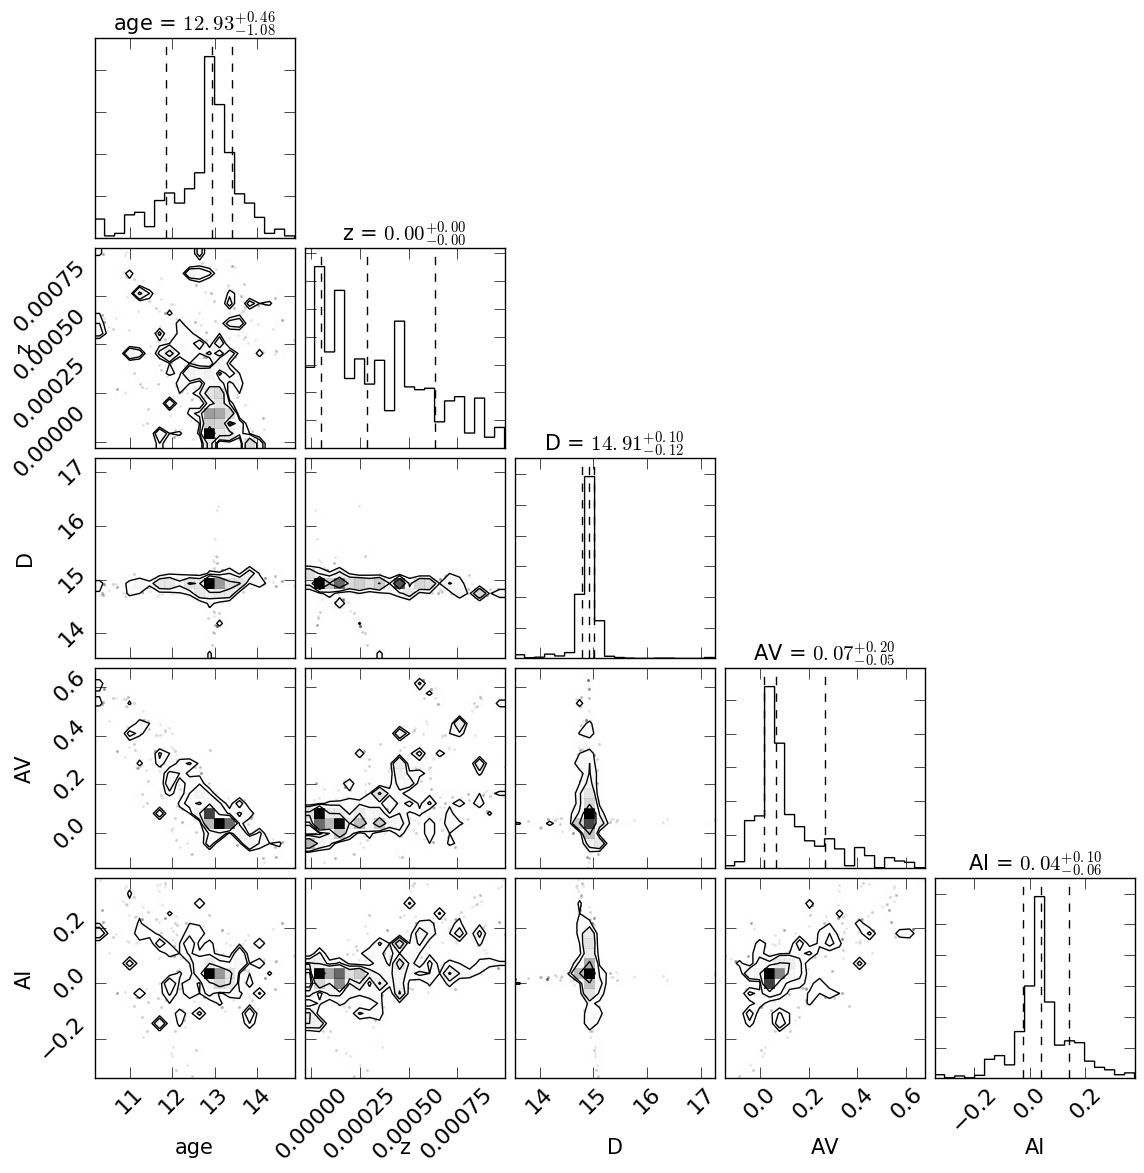

In [96]:
samples = sampler.chain.reshape((-1, ndim))
corner.corner(samples, labels=['age', 'z', 'D', 'AV', 'AI'],quantiles=[0.16, 0.5, 0.84], show_titles=True)

I adopt pretty strong prior on distance modulus, the plot shows that I can constrain age, distance, extinction pretty well, but it's really hard to constrain on metallicity.

(c)

In [99]:
sig = 0.01
V_obs, I_obs = np.random.normal((V_true, I_true), sig)
print('V_obs = %.2f, I_obs = %.2f' %(V_obs, I_obs))

V_obs = 21.08, I_obs = 20.44


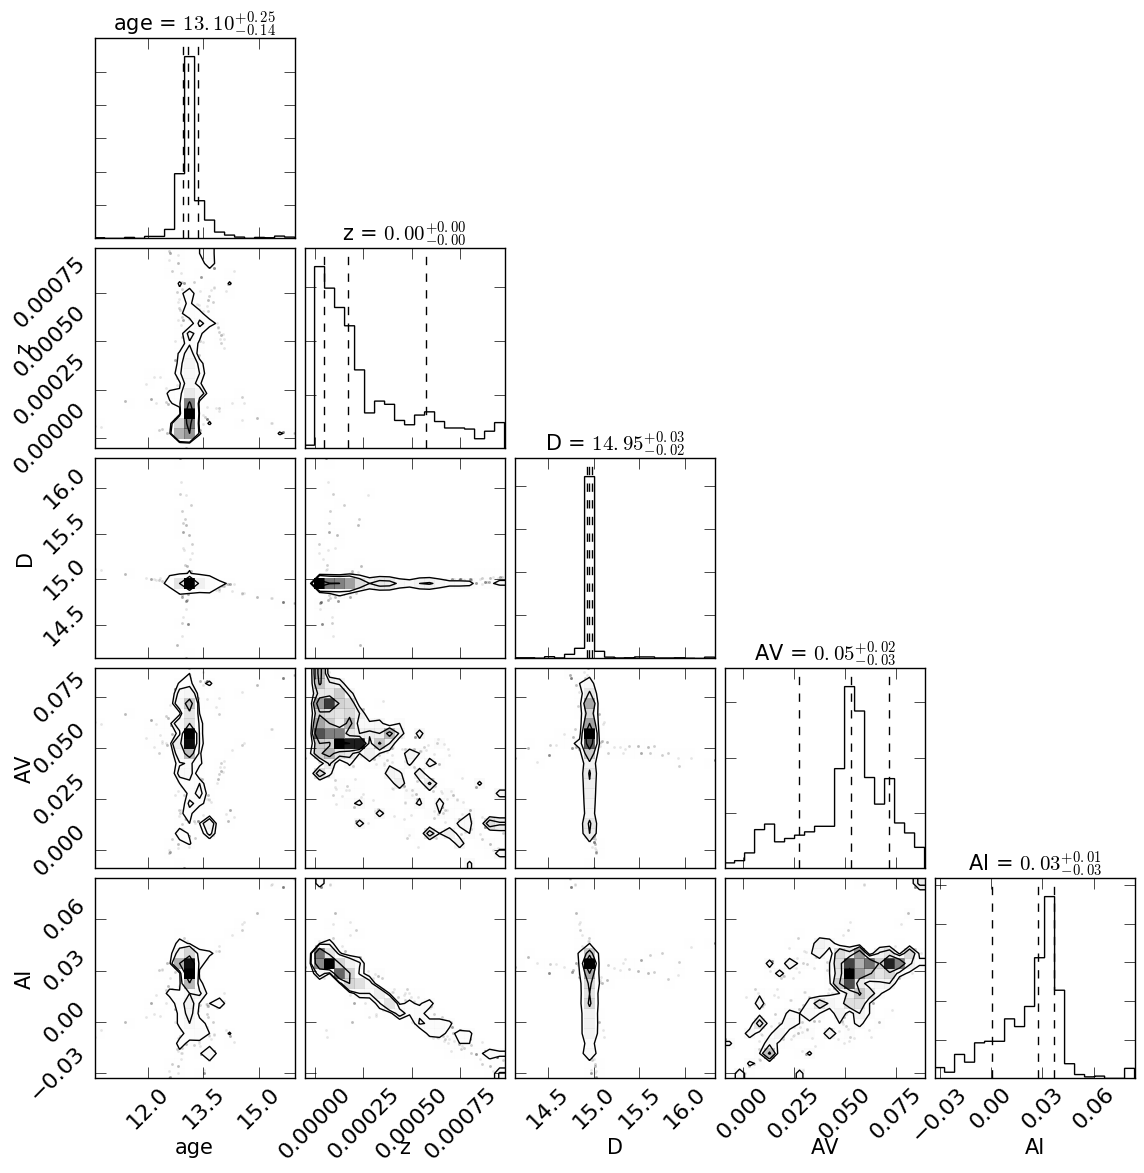

In [100]:
steps = 100
nwalkers = 10
ndim = 5
theta0 = [13, 0.0001, 15, 0.05, 0.03]
pos = [np.random.normal((theta0), (0.1, 0.0001, 1, 0.01, 0.01)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(V_obs, I_obs))
sampler.run_mcmc(pos, steps)
samples = sampler.chain.reshape((-1, ndim))
corner.corner(samples, labels=['age', 'z', 'D', 'AV', 'AI'],quantiles=[0.16, 0.5, 0.84], show_titles=False)
print('')

Overall the results is closer to the real value and with smaller uncertainties. Especially for metallicity, z is convergent to its real value 0.0002. 

(d)

In [7]:
def calc_UBVI(age, z, D, AU, AB, AV, AI):
    sp = fsps.StellarPopulation(compute_vega_mags=True, sfh=0, zcontinuous=z)
    mags = sp.get_mags(bands=['wfc3_uvis_f336w', 'wfc3_uvis_f438w', 'wfc3_uvis_f555w', 'wfc3_uvis_f814w'], tage=age )
    U = mags.T[0]
    B = mags.T[1]
    V = mags.T[2]
    I = mags.T[3]
    
    U_obs = U + D + AU
    B_obs = B + D + AB
    V_obs = V + D + AV
    I_obs = I + D + AI
    
    return U_obs, B_obs, V_obs, I_obs

U_true, B_true, V_true, I_true = calc_UBVI(14, 0.0002, 14.9, 0.096, 0.081, 0.061, 0.034)
print('U_true = %.2f   B_true=%.2f  V_true = %.2f, I_true = %.2f' %(U_true, B_true, V_true, I_true))

U_true = 21.87   B_true=21.86  V_true = 21.33, I_true = 20.44


In [10]:
def lnprior(theta):
    age, z, D, AU, AB, AV, AI = theta
    if age>10 and age<16:
        ln_age = 0
    else:
        ln_age = -np.inf
        
    if z>0 and z<0.001:
        ln_z = 0
    else:
        ln_z = -np.inf   

    
    D_mean = 14.9
    D_error = 0.1
    ln_D = -np.log(D_error) - (D-D_mean)**2/(2*D_error**2)
    
    ln_p = ln_age + ln_z + ln_D
    
    return ln_p

def lnlike(theta, U_obs, B_obs, V_obs, I_obs):
    age, z, D, AU, AB, AV, AI = theta
    U,B,V,I = calc_UBVI(age, z, D, AU, AB, AV, AI)
    ln_p = -4*np.log(sig) -  (U_obs-U)**2/(2*sig**2)  - (B_obs-B)**2/(2*sig**2)\
            -  (V_obs-V)**2/(2*sig**2)  - (I_obs-I)**2/(2*sig**2)
    return ln_p

def lnprob(theta, U_obs, B_obs, V_obs, I_obs):
    return lnprior(theta) + lnlike(theta, U_obs, B_obs, V_obs, I_obs)

In [11]:
sig = 0.1
U_obs, B_obs, V_obs, I_obs = np.random.normal((U_true, B_true, V_true, I_true), sig)
print('U_obs = %.2f   B_obs = %.2f   V_obs = %.2f, I_obs = %.2f' %(U_obs, B_obs, V_obs, I_obs))

U_obs = 21.84   B_obs = 22.16   V_obs = 21.31, I_obs = 20.48


In [13]:
steps = 100
nwalkers = 20
ndim = 7
theta0 = [13, 0.0001, 15, 0.09, 0.08, 0.06, 0.03]
pos = [np.random.normal((theta0), (0.1, 0.0001, 1, 0.01, 0.01, 0.01, 0.01)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(U_obs, B_obs, V_obs, I_obs))
sampler.run_mcmc(pos, steps)
samples = sampler.chain.reshape((-1, ndim))

/Users/siyao/Applications/anaconda3/envs/python27/lib/python2.7/site-packages/emcee-2.2.1-py2.7.egg/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/siyao/Applications/anaconda3/envs/python27/lib/python2.7/site-packages/emcee-2.2.1-py2.7.egg/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


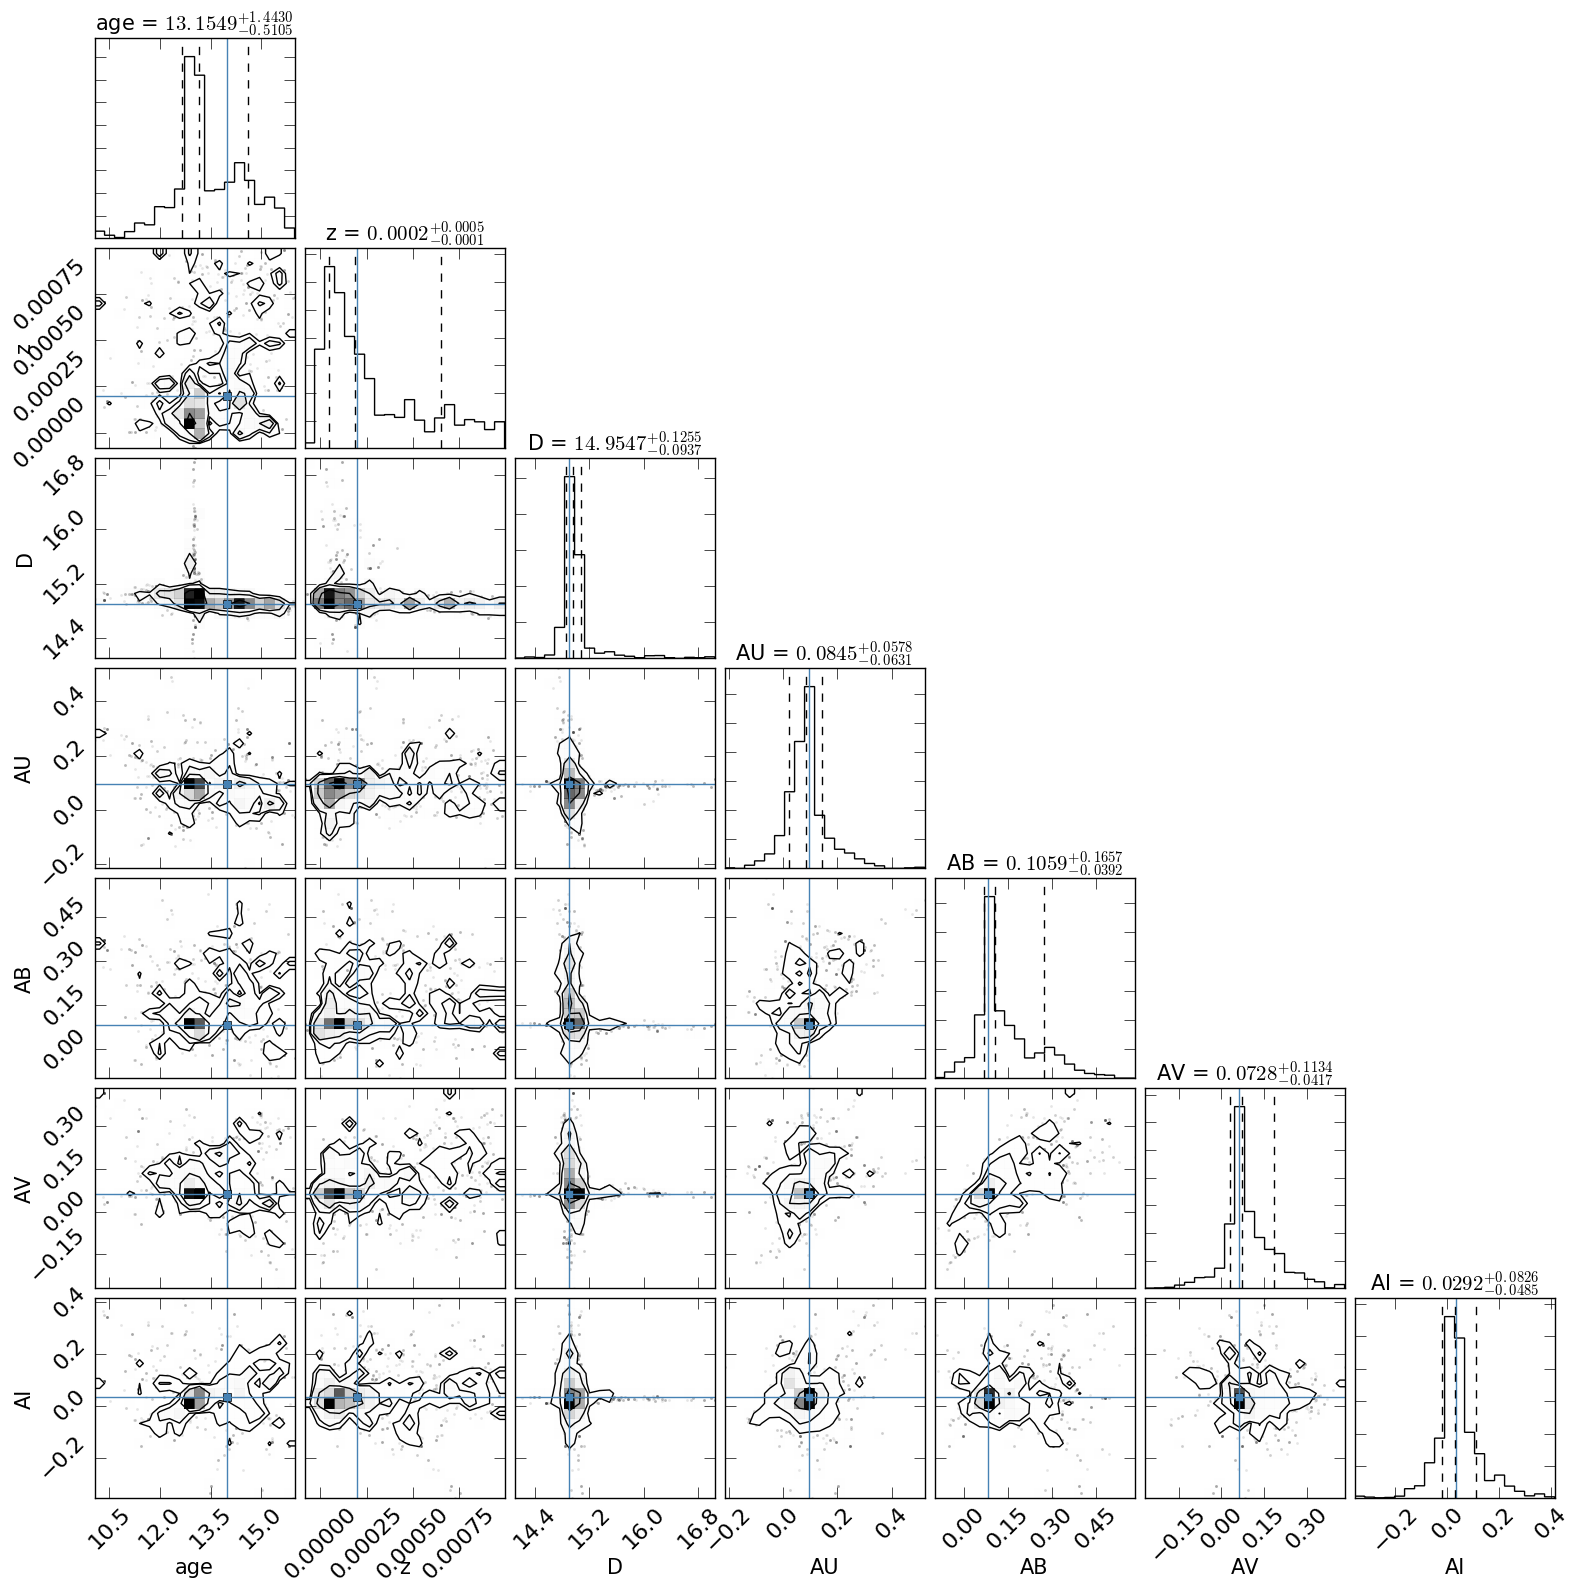

In [27]:
corner.corner(samples, labels=['age', 'z', 'D', 'AU', 'AB', 'AV', 'AI'],\
              quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='.4f', truths=[14, 0.0002, 14.9, 0.096, 0.081, 0.061, 0.034 ])

Compared with (b), we can see with more photometry, we can definitely constrain age, metallicity, distance modulues better. For the extinction, I notice that observation magnitude for B filter deviate from the true value most, so the extinction for B filter is also away from the expected extionction most. For U, V, I filter, the extinction from mcmc is more close to its true value.

(d)

I can't find the FUV extinction for M92 whose effecitive wavelength is 1535 ang. The nearest extiontion I can find is 0.173 for 2200 ang. I decide to use 0.2 for FUV which might not be accurate but will make some reasonable prediction for this question.

In [29]:
def calc_UBVI(age, z, D, AFUV, AU, AB, AV, AI):
    sp = fsps.StellarPopulation(compute_vega_mags=True, sfh=0, zcontinuous=z)
    mags = sp.get_mags(bands=['galex_fuv', 'wfc3_uvis_f336w', 'wfc3_uvis_f438w', 'wfc3_uvis_f555w', 'wfc3_uvis_f814w'], tage=age )
    FUV = mags.T[0]
    U = mags.T[1]
    B = mags.T[2]
    V = mags.T[3]
    I = mags.T[4]
    
    FUV_obs = FUV + D + AFUV 
    U_obs = U + D + AU
    B_obs = B + D + AB
    V_obs = V + D + AV
    I_obs = I + D + AI
    
    return FUV_obs, U_obs, B_obs, V_obs, I_obs

FUV_true, U_true, B_true, V_true, I_true = calc_UBVI(14, 0.0002, 14.9, 0.2, 0.096, 0.081, 0.061, 0.034)
print('FUV_true=%.2f  U_true=%.2f   B_true=%.2f  V_true=%.2f, I_true=%.2f' %(FUV_true, U_true, B_true, V_true, I_true))

FUV_true=24.39  U_true=21.87   B_true=21.86  V_true=21.33, I_true=20.44


In [30]:
def lnprior(theta):
    age, z, D, AFUV, AU, AB, AV, AI = theta
    if age>10 and age<16:
        ln_age = 0
    else:
        ln_age = -np.inf
        
    if z>0 and z<0.001:
        ln_z = 0
    else:
        ln_z = -np.inf   

    
    D_mean = 14.9
    D_error = 0.1
    ln_D = -np.log(D_error) - (D-D_mean)**2/(2*D_error**2)
    
    ln_p = ln_age + ln_z + ln_D
    
    return ln_p

def lnlike(theta, FUV_obs, U_obs, B_obs, V_obs, I_obs):
    age, z, D, AFUV, AU, AB, AV, AI = theta
    FUV,U,B,V,I = calc_UBVI(age, z, D, AFUV, AU, AB, AV, AI)
    ln_p = -5*np.log(sig) -  (FUV_obs-FUV)**2/(2*sig**2) - (U_obs-U)**2/(2*sig**2) - (B_obs-B)**2/(2*sig**2)\
            -  (V_obs-V)**2/(2*sig**2)  - (I_obs-I)**2/(2*sig**2)
    return ln_p

def lnprob(theta, FUV_obs, U_obs, B_obs, V_obs, I_obs):
    return lnprior(theta) + lnlike(theta, FUV_obs, U_obs, B_obs, V_obs, I_obs)

In [31]:
sig = 0.1
FUV_obs, U_obs, B_obs, V_obs, I_obs = np.random.normal((FUV_true, U_true, B_true, V_true, I_true), sig)
print('FUV_obs=%.2f   U_obs=%.2f   B_obs=%.2f   V_obs=%.2f  I_obs=%.2f' %(FUV_obs, U_obs, B_obs, V_obs, I_obs))

FUV_obs=24.40   U_obs=21.83   B_obs=21.74   V_obs=21.38  I_obs=20.35


In [32]:
steps = 100
nwalkers = 30
ndim = 8
theta0 = [13, 0.0001, 15, 0.22, 0.09, 0.08, 0.06, 0.03]
pos = [np.random.normal((theta0), (0.1, 0.0001, 1, 0.01, 0.01, 0.01, 0.01, 0.01)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(FUV_obs, U_obs, B_obs, V_obs, I_obs))
sampler.run_mcmc(pos, steps)
samples = sampler.chain.reshape((-1, ndim))

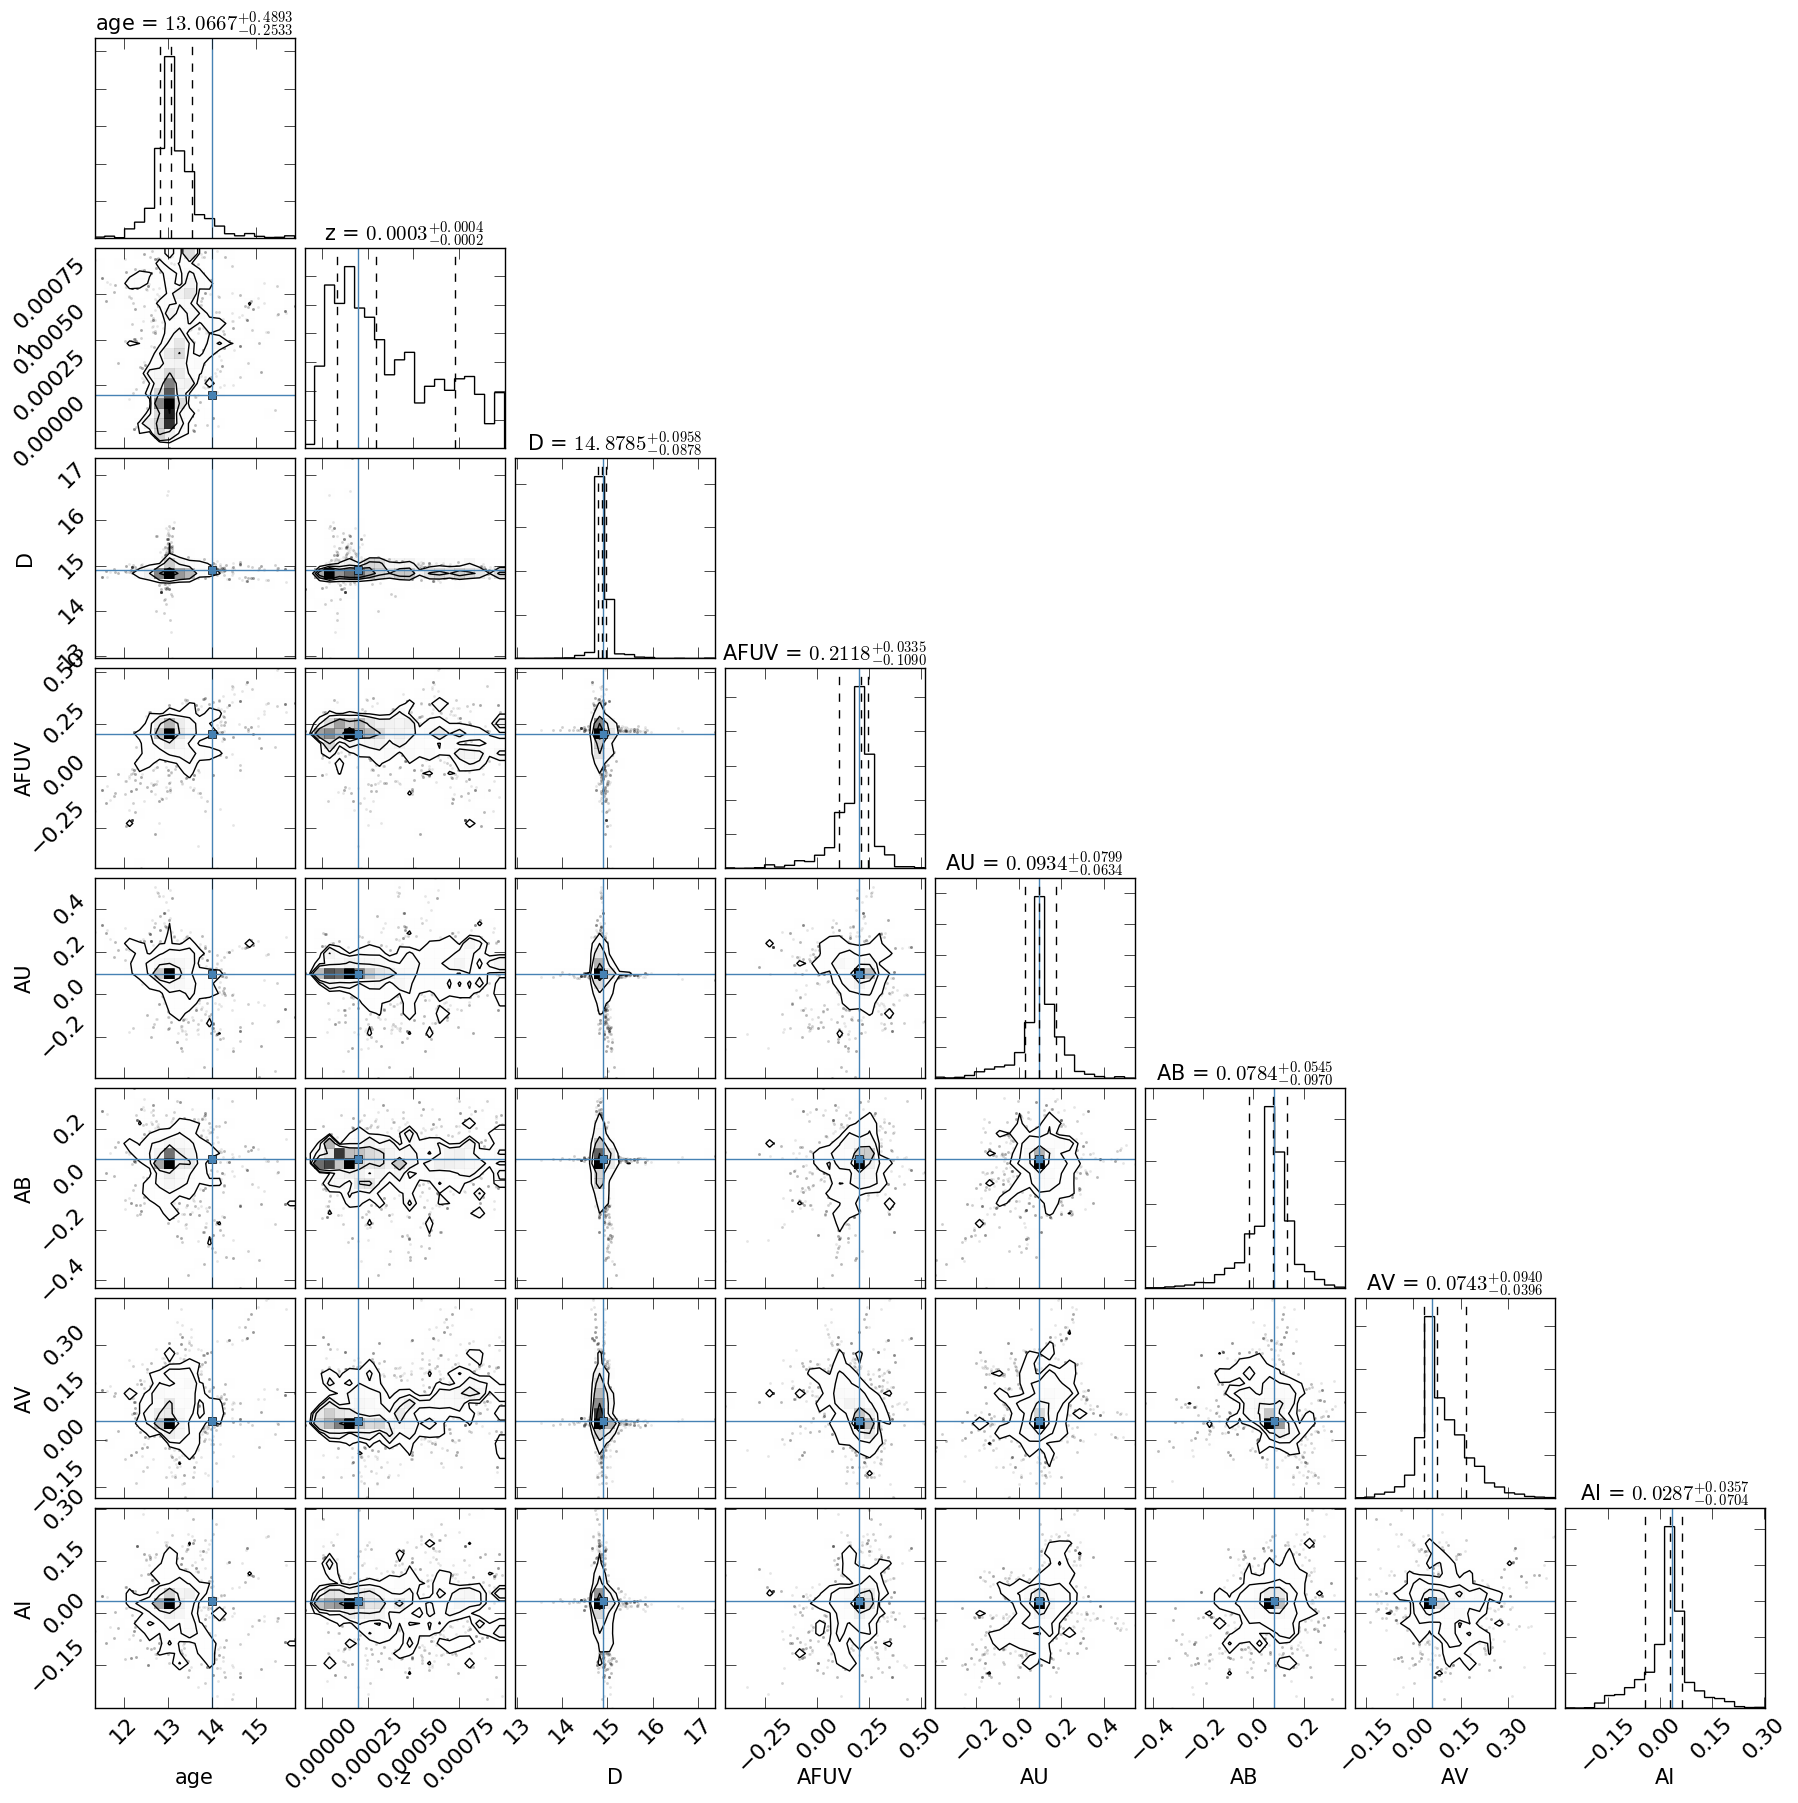

In [34]:
corner.corner(samples, labels=['age', 'z', 'D', 'AFUV', 'AU', 'AB', 'AV', 'AI'],\
              quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='.4f', truths=[14, 0.0002, 14.9, 0.2, 0.096, 0.081, 0.061, 0.034])
print(' ')

With FUV filter, age, z and distance modulus all seem to be constrained with smaller uncertainties, although it doesn't actually make the results more close to the real value. 

One challenge of using UV to observe star clusters is that extiction is high in shorter wavelength, so deriving accurate extinction will be challenging and it's also hard to observe if the extionction is too high which will make the star cluster faint. What's more, we can't observe UV in the ground because of earth's atmosphere. If we want to observe in UV, we will have to use space telescope.